# Unsupervised outliers detection (event detection)

In [1]:
import drama as drm
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec

from keras.datasets import mnist

%matplotlib inline

Using TensorFlow backend.


In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size*image_size])
x_test = np.reshape(x_test, [-1, image_size*image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [17]:
inlier_labels = [1,2,3,4]
outlier_labels = [5]
n_inliers = 2000
n_outliers = 50

X = []
y = []
for i in inlier_labels:
    filt = y_train==i
    ns = np.sum(filt)
    X.extend(x_train[filt][:n_inliers])
    y.extend(n_inliers*[0])
    
for i in outlier_labels:
    filt = y_train==i
    ns = np.sum(filt)
    X.extend(x_train[filt][:n_outliers])
    y.extend(n_outliers*[1])
    
X = np.array(X)
y = np.array(y)

In [18]:
X.shape,y.shape

((8050, 784), (8050,))

# Outlier detection

In [ ]:
n_try = 5

result = []
for i in range(n_try):
    auc,mcc,rws,conf = drm.grid_run_drama(X,y)
    arr = np.stack([auc,mcc,rws],axis=-1)
    result.append(arr)
result = np.array(result)

drts = np.unique(conf[:,1])
metrs = np.unique(conf[:,2])

res = result.reshape(n_try,5,10,-1)

Unsupervised outlier detection mode.


W1116 12:43:44.204319 140312444520256 training_utils.py:1348] Output dense_6 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_6.


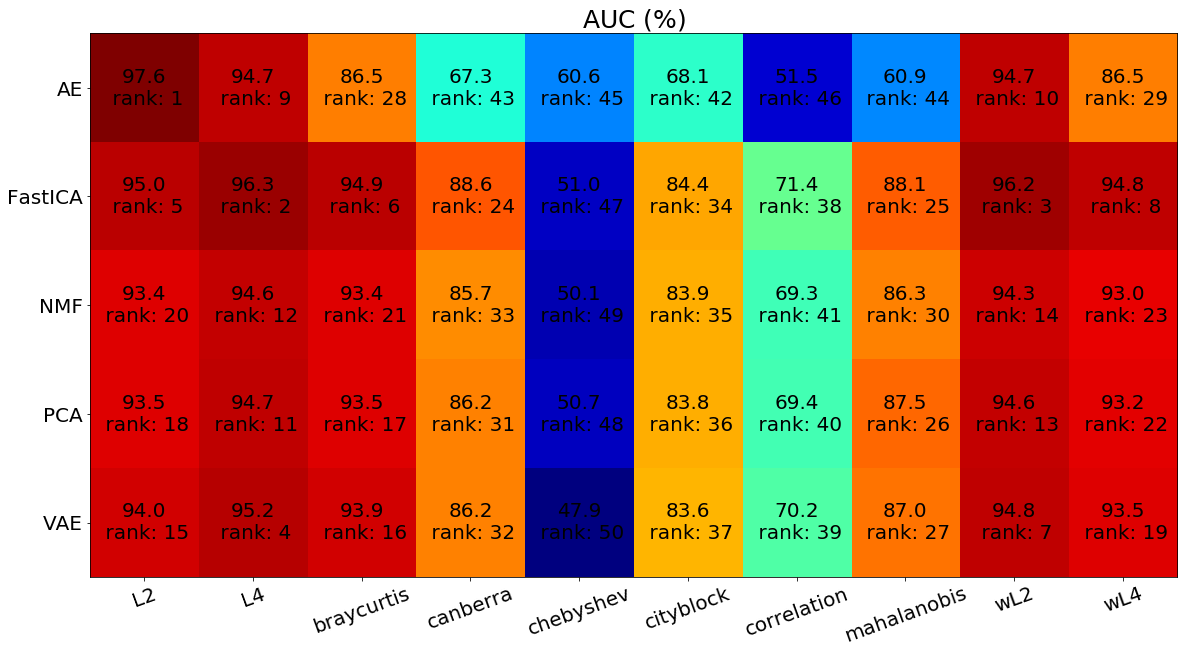

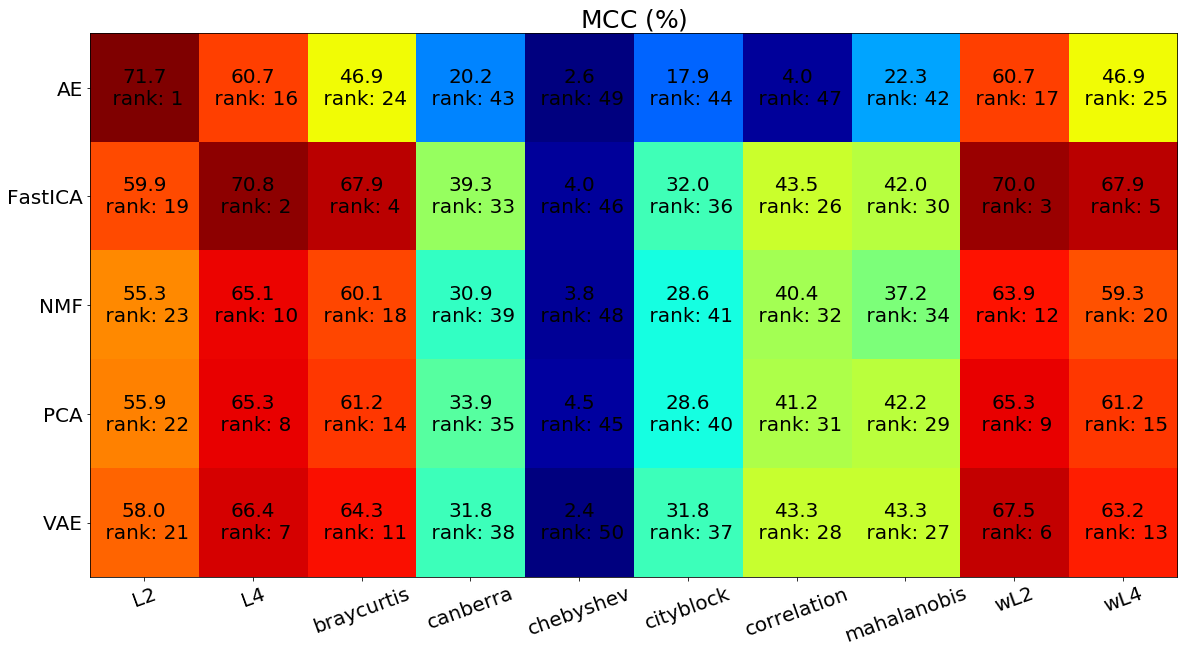

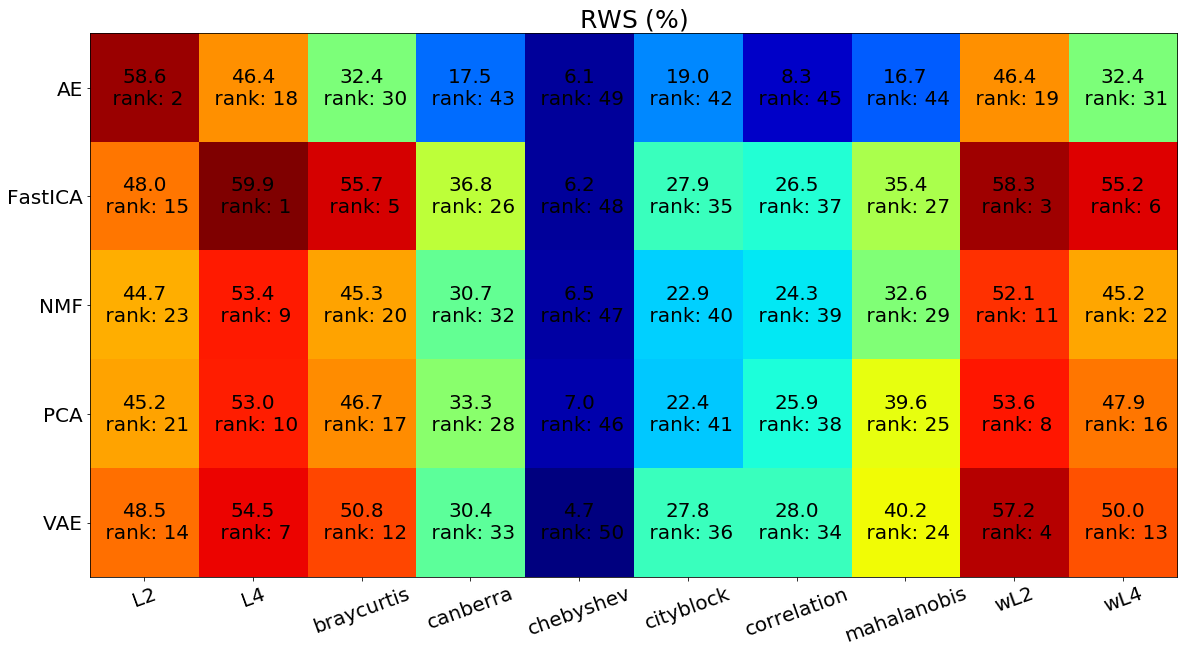

In [5]:
drm.plot_table(np.mean(res,axis=0),drts,metrs)

In [6]:
lof_all = np.zeros((n_try,3))
ifr_all = np.zeros((n_try,3))
df = drm.sk_check(X,X,y,[1])
for i in range(n_try):
    for j,scr in enumerate(['AUC','MCC','RWS']):
        lof_all[i,j] = df[scr][0]
        ifr_all[i,j] = df[scr][1]

NameError: name 'neighbors' is not defined

In [ ]:
auc = np.sum((res[:, :, :, 0].T>lof_all[:, 0]) & (res[:, :, :, 0].T>ifr_all[:, 0]),axis=-1).T
mcc = np.sum((res[:, :, :, 1].T>lof_all[:, 1]) & (res[:, :, :, 1].T>ifr_all[:, 1]),axis=-1).T
rws = np.sum((res[:, :, :, 2].T>lof_all[:, 2]) & (res[:, :, :, 2].T>ifr_all[:, 2]),axis=-1).T

fig = plt.figure(figsize=(20,10))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect('auto')
ax.imshow(auc, cmap=plt.cm.jet,interpolation='nearest')

width, height = auc.shape

for x in range(width):
    for y in range(height):
        ax.annotate('AUC: {:d}\n MCC: {:d}\n RWS: {:d}'.format(auc[x][y],mcc[x][y],rws[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center',fontsize=18);

plt.xticks(range(10),metrs,fontsize=15)
plt.yticks(range(5), drts,fontsize=15)

plt.title('Number of successes (LOF and i-forest) out of 20 data set',fontsize=25)
plt.annotate('** Colors depend on AUC.', (0,0), (0, -30), xycoords='axes fraction',
             textcoords='offset points', va='top',fontsize=15)

# plt.savefig('AND_success.jpg',dpi=150,bbox_inches='tight')